In [26]:
import pandas as pd
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Load CSV file
df = pd.read_csv("EPS_711_DATA.csv")
print(f"Loaded {len(df)} reviews.")
df.head()

Loaded 104 reviews.


,location,zip_code,review_text,star_rating,avg_income,date
0,AFC Urgent Care Anaheim- Katella Ave,92804,I came to AFC for a TB test and health screeni...,five,"~90,583",8/14/25
1,AFC Urgent Care Anaheim- Katella Ave,92804,I had to go two days in a row. The first day I...,two,"~90,583",7/20/25
2,AFC Urgent Care Anaheim- Katella Ave,92804,I would not recommend. $185 visit to just get ...,one,"~90,583",7/6/25
3,AFC Urgent Care Anaheim- Katella Ave,92804,I went here for an employment health screening...,five,"~90,583",7/2/25
4,AFC Urgent Care Anaheim- Katella Ave,92804,SAVE YOUR TIME- GO TO THE ER\n\nWe had a 4:00 ...,one,"~90,583",6/30/25


In [27]:
import nltk 
import re
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove links
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    words = text.split()
    return " ".join([word for word in words if word not in stop_words])
    df["clean_text"] = df["review_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michellenkoudou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
#Define Helper Functions
def remove_emojis(text):
    """
    Removes most common Unicode emoji characters.
    """
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    """
    Preprocesses review text:
    - Lowercase
    - Remove emojis
    - Replace repeated punctuation
    - Remove extra spaces
    """
    text = str(text).lower()
    text = remove_emojis(text)
    text = re.sub(r'[!?]+', '!', text)  # normalize punctuation
    text = re.sub(r'\s+', ' ', text)  # collapse whitespace
    return text.strip()

# ---------------------------
#Preprocessing to Your Reviews
# ---------------------------
df["clean_text"] = df["review_text"].apply(preprocess_text)
df["clean_text"].head()
# ---------------------------
# 4) Vectorization (Convert text to document-term matrix)
# ---------------------------
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df["clean_text"])
# 5) Topic Modeling with LDA
# ---------------------------
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

# Show top words in each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print()

Topic #1:
['quick', 'time', 'helpful', 'service', 'professional', 'friendly', 'urgent', 'great', 'care', 'staff']

Topic #2:
['days', 'said', 'did', 'like', 'came', 'visit', 'went', 'doctor', 'just', 'time']

Topic #3:
['service', 'provider', 'thank', 'excellent', 'doctor', 'ma', 'come', 'lee', 'chika', 'care']



In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply VADER scoring
df['vader_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify into categories
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_score'].apply(classify_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michellenkoudou/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


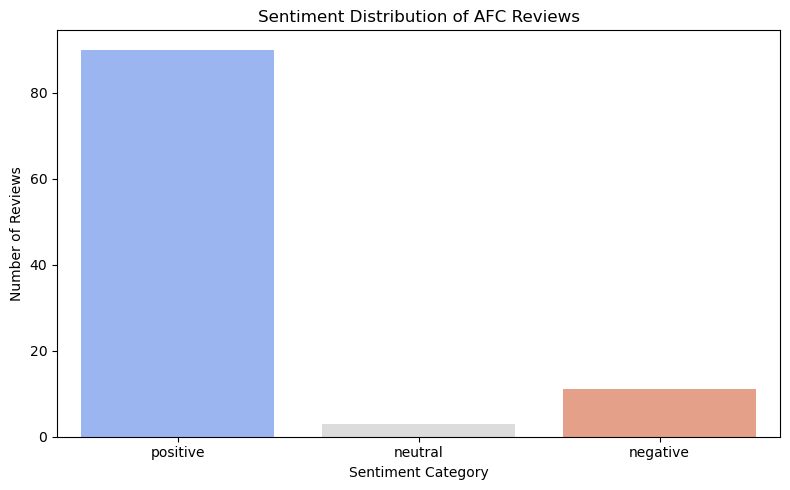

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot of sentiment categories
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='vader_sentiment', order=['positive', 'neutral', 'negative'], palette='coolwarm')

# Customize chart
plt.title('Sentiment Distribution of AFC Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()